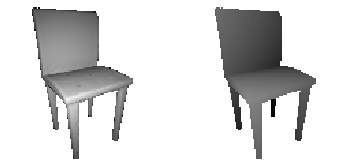

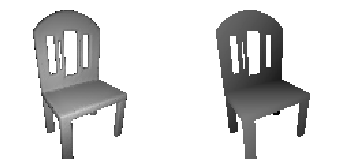

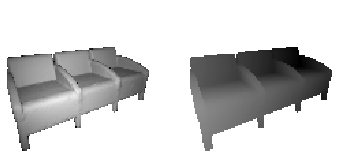

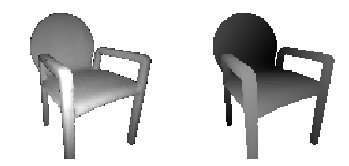

/home/maxjiang/software/anaconda3/lib/python3.7/site-packages/trimesh/triangles.py:109: RuntimeWarning: invalid value encountered in true_divide
  u /= util.row_norm(u).reshape((-1, 1))
/home/maxjiang/software/anaconda3/lib/python3.7/site-packages/trimesh/triangles.py:110: RuntimeWarning: invalid value encountered in true_divide
  v /= util.row_norm(v).reshape((-1, 1))
/home/maxjiang/software/anaconda3/lib/python3.7/site-packages/trimesh/triangles.py:111: RuntimeWarning: invalid value encountered in true_divide
  w /= util.row_norm(w).reshape((-1, 1))


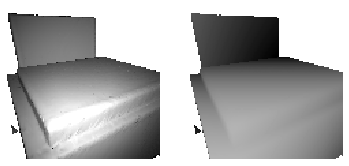

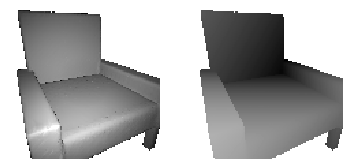

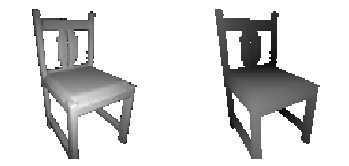

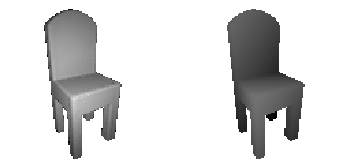

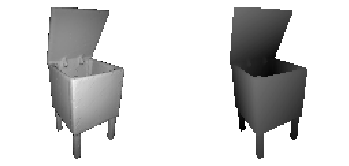

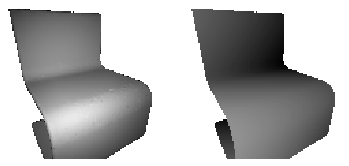

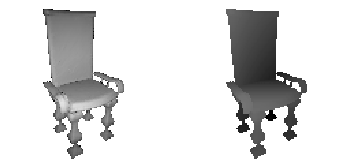

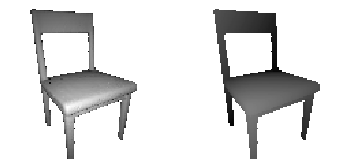

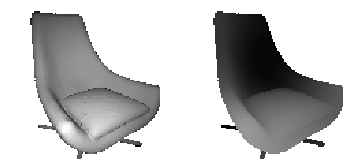

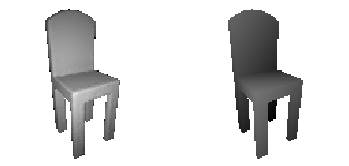

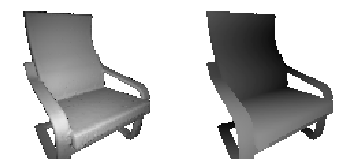

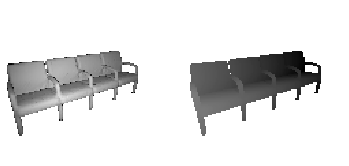

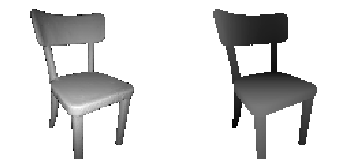

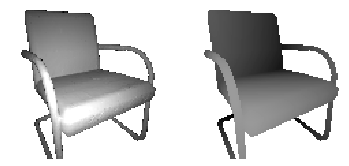

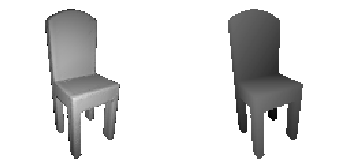

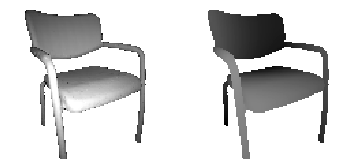

In [463]:
# Render offscreen -- make sure to set the PyOpenGL platform
from utils import render
import glob

meshnames = sorted(glob.glob('data/shapenet_simplified/val/03001627/*/*.ply'))
eye_1 = [.8, .4, .5]
eye_2 = [.3, .4, .9]
center = [0, 0, 0]
up = [0, 1, 0]

for idx in range(20):
    color, depth, _, _ = render.render_trimesh(trimesh.load(meshnames[idx]), eye_1, center, up, res=(112, 112), light_intensity=6)
    # Show the images
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.figure()
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.imshow(color)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.imshow(depth, cmap=plt.cm.gray_r)
    plt.show()

## Unproject depth map to point cloud

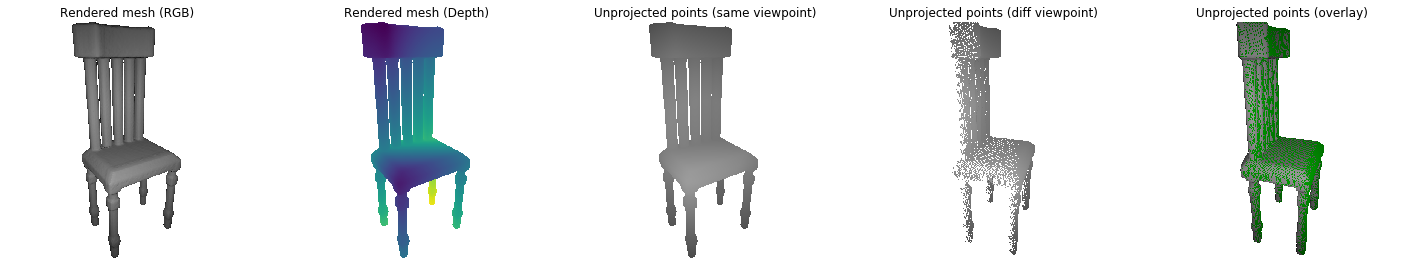

In [465]:
# take a sample point cloud from a shape
m = trimesh.load("data/shapenet_watertight/val/03001627/bcc73b8ff332b4df3d25ee35360a1f4d/model_occnet.ply")

eye_1 = [.8, .4, .5]
eye_2 = [.3, .4, .9]
center = [0, 0, 0]
up = [0, 1, 0]
img, depth, world2cam, cam2img = render_trimesh(m, eye_1, center, up, light_intensity=3)
points_unproj = unproject_depth_img(depth, cam2img, world2cam)
points_unproj_img_sameview, _, _, _ = render_trimesh(trimesh.PointCloud(points_unproj), 
                                                     eye_1, center, up, light_intensity=3)
points_unproj_img_diffview, _, _, _ = render_trimesh(trimesh.PointCloud(points_unproj), 
                                                     eye_2, center, up, light_intensity=3)
colors = np.zeros_like(points_unproj); colors[:, 1] = 1
points_unproj_img_overlay, _, _, _ = render_trimesh([trimesh.PointCloud(points_unproj, colors=colors),
                                                     m], eye_2, center, up, light_intensity=3)

fig, axes = plt.subplots(figsize=(25, 5), ncols=5)
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title("Rendered mesh (RGB)")

d = depth.copy()
d[depth==0] = np.nan
axes[1].set_title("Rendered mesh (Depth)")
c = axes[1].imshow(d)
axes[1].axis('off')

axes[2].imshow(points_unproj_img_sameview)
axes[2].axis('off')
axes[2].set_title("Unprojected points (same viewpoint)")

axes[3].imshow(points_unproj_img_diffview)
axes[3].axis('off')
axes[3].set_title("Unprojected points (diff viewpoint)")

axes[4].imshow(points_unproj_img_overlay)
axes[4].axis('off')
axes[4].set_title("Unprojected points (overlay)")

# fig.colorbar(c, ax=axes[1])
plt.show()